## Customer Lifetime Value Prediction - Wenyi Yan

### Project Goals:
Answer following questions:
- How many times will customers purchase in 90 days (i.e Frequencies)
- How much will customers spend in 90 days (i.e Monatry values)
- What's the customer lifetime values in 90 days (i.e CLV)

### Project Features:
- These models are simple, effective, and quite accurate on purchase behaviors prediction comparing to other complex machine learning models
- Transaction data is what all needed, so reduced complexity of data cleaning which is user friendly

In [1]:
#Connect BigQuery API
import os
import time
from google.cloud import bigquery

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import confusion_matrix
import seaborn as sns
import datetime
from sklearn.metrics import mean_absolute_error, f1_score

from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data, summary_data_from_transaction_data
from lifetimes.plotting import plot_period_transactions, plot_frequency_recency_matrix, plot_probability_alive_matrix

os.environ['GOOGLE_APPLICATION_CREDENTIALS']='wy_ServiceKey_GCP.json'

client = bigquery.Client()

In [2]:
#Extract Data 'id', 'date', 'purchasequantity', 'purchaseamount' in one year
sql_query="""SELECT InvoiceNo, InvoiceDate, CustomerID, Quantity, UnitPrice
FROM OnlineRetail.OnlineRetail_transformed
WHERE InvoiceDate <='2021-11-30'
""" 

query_job = client.query(sql_query)

while query_job.state != 'DONE':
    query_job.reload()
    time.sleep(3) #check again after 3 secs
    
if query_job.state == "DONE":
    df=query_job.to_dataframe()
else:
    print(query_job.result())

## Data exploration
Finding: 
- There are about 20% missing customerID.
- There are 'quantity' < 0, this caused by cancelled orders (whose 'InvoiceNo' start from 'c') and cancelled items
 - All cancelled orders' quantity<0 

In [3]:
df.shape

(516384, 5)

In [4]:
df.describe()

,CustomerID,Quantity,UnitPrice
count,389168.000000,516384.000000,516384.000000
mean,15287.024473,9.586116,4.579709
std,1712.959478,156.331122,94.287694
min,12346.000000,-74215.000000,-11062.060000
25%,13952.000000,1.000000,1.250000
50%,15154.000000,3.000000,2.080000
75%,16788.000000,10.000000,4.130000
max,18287.000000,74215.000000,38970.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516384 entries, 0 to 516383
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    516384 non-null  object 
 1   InvoiceDate  516384 non-null  dbdate 
 2   CustomerID   389168 non-null  Int64  
 3   Quantity     516384 non-null  Int64  
 4   UnitPrice    516384 non-null  float64
dtypes: Int64(2), dbdate(1), float64(1), object(1)
memory usage: 20.7+ MB


In [6]:
#Check if all quantity<0 caused by cancelled transaction (cancelled InvoiceNo start with 'c')
df.loc[df['Quantity']<0].InvoiceNo.map(lambda x: str(x)[0]=='C').value_counts()

True     8928
False    1306
Name: InvoiceNo, dtype: int64

In [7]:
#dive deep in normal transaction with quantity<0
df[df.InvoiceNo.map(lambda x: str(x)[0]!='C')].query('Quantity <0').head()

,InvoiceNo,InvoiceDate,CustomerID,Quantity,UnitPrice
5017,536589,2020-12-01,<NA>,-10,0.0
5082,536764,2020-12-02,<NA>,-38,0.0
5264,536996,2020-12-03,<NA>,-20,0.0
5265,536997,2020-12-03,<NA>,-20,0.0
5266,536998,2020-12-03,<NA>,-6,0.0


In [8]:
#how many cancelled transactions
df.InvoiceNo.map(lambda x: str(x)[0]=='C').value_counts()

False    507456
True       8928
Name: InvoiceNo, dtype: int64

## Data Cleaning 
- Drop cancelled orders and items records(which are not monatized)
- Drop missing CustomerID records(bc we can't trace back to the customer )

In [9]:
# Drop cancelled orders and items records(which are not monatized)
df.query('Quantity>0 & UnitPrice>0', inplace=True)

#Drop missing cutomerID records
df.dropna(inplace=True)

## Feature Engineering
- create sales feature (sales=quantity*UnitPrice)

In [10]:
df['Sales']=df.Quantity*df.UnitPrice

In [11]:
df = df[['InvoiceNo','InvoiceDate','CustomerID','Sales']]

In [12]:
#change CustomerID's datatype from number to object
df.CustomerID=df.CustomerID.astype('object')
#get invoice info - unique invoiceNo and customerID
df.nunique()

InvoiceNo      17754
InvoiceDate      297
CustomerID      4297
Sales           2871
dtype: int64

## Data Exploration
- The dataset includes 4338 unique customers' data from 2020-12-1 to 2021-11-30
- Sales trend is generally steady with a few seasonality caused by holidays and events like Christmas and school opening
- Sales distribution by customer vary a lot with high standard deviation: 50% customers purchase under \\$660, 25% customer purchase between \\$660-\\$1600 and rest of them are VIP customer spending between \\$1600 and \\$26000 
- Frequency distibution is heavily left skewed with 50% customers had only 1-2 purchases, and the most frequent customer had 127 purchases

In [13]:
print('Dataset size:',df.shape)
df.head()

Dataset size: (380580, 4)


,InvoiceNo,InvoiceDate,CustomerID,Sales
100,572215,2021-10-21,12646,26.56
101,572215,2021-10-21,12646,40.0
102,536540,2020-12-01,14911,42.5
103,536890,2020-12-03,14156,230.4
104,536890,2020-12-03,14156,61.2


In [14]:
print(df.InvoiceDate.min())
print(df.InvoiceDate.max())

2020-12-01
2021-11-30


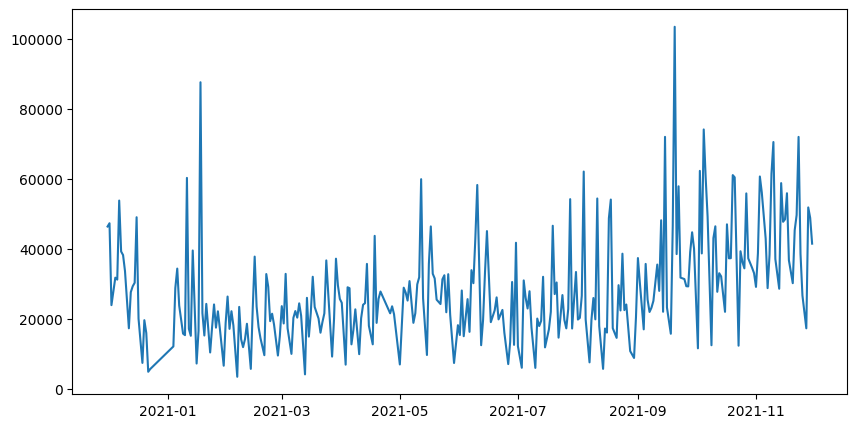

In [15]:
#Check sales trend
sales = df.groupby('InvoiceDate')['Sales'].sum()
plt.figure(figsize=(10, 5))
plt.plot(sales)

In [16]:
print(f'Unique Customers: {df["CustomerID"].nunique()}')
print(f'Unique Days: {df["InvoiceDate"].nunique()}')

Unique Customers: 4297
Unique Days: 297


In [17]:
#sales per person explore
sales_per_person = df.groupby('CustomerID')['Sales'].sum()
sales_per_person.to_frame().describe()

,Sales
count,4297.000000
mean,1953.273240
std,8355.832473
min,2.900000
25%,304.470000
50%,657.300000
75%,1600.860000
max,268478.000000


In [18]:
#freq per person explore
sales_per_person = df.groupby('CustomerID')['InvoiceDate'].nunique()
sales_per_person.to_frame().describe()

,InvoiceDate
count,4297.000000
mean,3.736793
std,5.728886
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,127.000000


## Modelling and Evaluation
The modelling & evaluation process is going to be the following:

1. Split into train and test periods
2. Fit and evaluate BG/NBD model for frequency prediction
3. Fit and evaluate Gamma-Gamma model for monetary value prediction
4. Combine 2 models into CLV model and compare to baseline
5. Refit the model on the entire dataset

### 1. Train Test Split
#### Split - 9 months data for traning, 3 months(i.e 90 days) data for testing:

In [19]:
#<>_cal: actual data for training; <>_holdout: actual data for testing
rfm_train_test = calibration_and_holdout_data(df, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2021-8-31',
                                        observation_period_end='2021-11-30',
                                                  monetary_value_col = 'Sales')  

In [20]:
#Filter out the customers who didn't make a repeat purchase since we can't really make a prediction base on them
rfm_train_test = rfm_train_test.loc[(rfm_train_test.frequency_cal > 0) & (rfm_train_test.frequency_holdout > 0), :]

In [21]:
rfm_train_test.head()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12347,4.0,238.0,267.0,519.7675,1.0,27.538723,91.0
12348,2.0,110.0,258.0,297.2200,1.0,103.333333,91.0
12352,3.0,34.0,196.0,421.7700,3.0,20.09,91.0
12356,1.0,80.0,225.0,481.4600,1.0,29.175,91.0
12359,2.0,142.0,231.0,1474.1150,1.0,27.398571,91.0


In [22]:
rfm_train_test.shape

(1338, 7)

### 2. BG/NBD model - predict customer's purchase frequency in 90 days

Conclustion: 
- The model predict will for when customer repeated purchanse frequency is from 1-7 times
- The model accuracy is pretty good: with average absolute error being about 1 purchase

#### Model Fitting

In [23]:
%%time
#Train the BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(rfm_train_test['frequency_cal'], rfm_train_test['recency_cal'], rfm_train_test['T_cal'])

CPU times: user 49.1 ms, sys: 1.44 ms, total: 50.6 ms
Wall time: 49.5 ms


<lifetimes.BetaGeoFitter: fitted with 1338 subjects, a: 0.00, alpha: 47.92, b: 0.00, r: 1.01>

In [24]:
#Predict
predicted_bgf = bgf.predict((datetime.datetime(2021, 11, 30)- datetime.datetime(2021, 8, 31)).days,
                        rfm_train_test['frequency_cal'], 
                        rfm_train_test['recency_cal'], 
                        rfm_train_test['T_cal'])

### 2.5 Customer behavior analysis for the next 90 days (Based on BG/NBD)
- Future frequency analysis: The longer the customers have been alive and the higher their historical freqency, the more possible they will frequently visit the store, which makes sense. 
 - Especially, in the future 90 days, the customers having more than 150 days ages and more than 70 times purchases are our most valueable customers with expected 20 times visites
- Future aliveness analysis:  two types of customers are most likely being alive: 1. new customers with not high repeat purchase freq 2. higher age cusotmers with higher repeat purcase freq

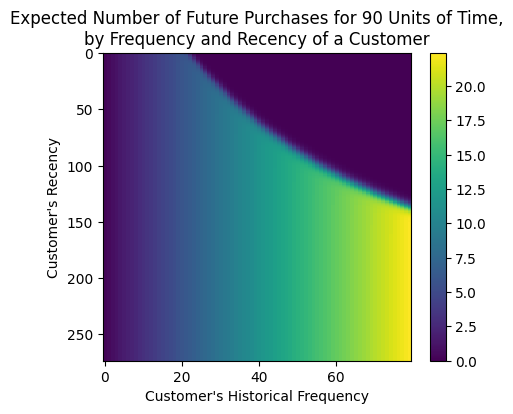

In [25]:
plt.subplots(figsize=(5,4))
plot_frequency_recency_matrix(bgf, T=90)  
plt.show()

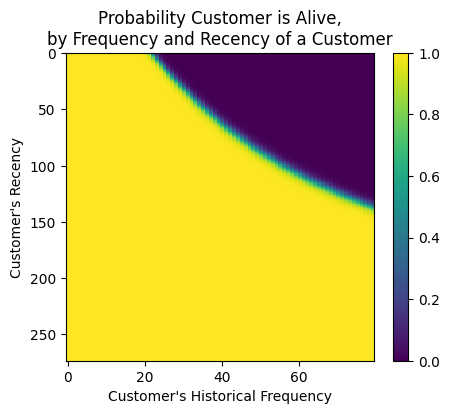

In [26]:
plt.subplots(figsize=(5,4))
plot_probability_alive_matrix (bgf)
plt.show()

#### Model Evaluation
##### Result in testing dataset: Actual vs Prediction
Generally under-predicted with 1 purchase difference, but generally well captured especially for low frequency purchase

<AxesSubplot: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

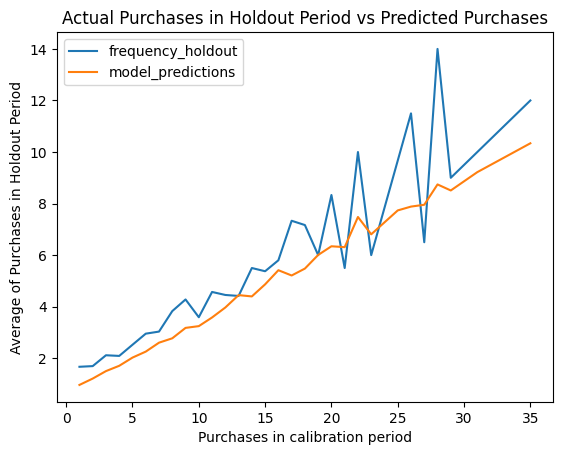

In [27]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
bgf.fit(rfm_train_test['frequency_cal'],rfm_train_test['recency_cal'],rfm_train_test['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf,rfm_train_test, n=30)

In [28]:
#numeric evaluation: MAE(mean absolute error) 
actual = rfm_train_test['frequency_holdout']
predicted = predicted_bgf
print(f"Average absolute error: {mean_absolute_error(actual, predicted)}")

Average absolute error: 1.0877466085676006


### 3. Gamma-Gamma Model - predict customer's average order spending in 90 days
- Prediction result is decent. 
    - Monetary Actual vs Predicted: predicted is little higher than actual around $6 for 75% variance

In [29]:
#gamma-gamma model's prerequisite is monetary_value and freq are not correlated. So need to validate this
##Finding: correlation coeffienct is lower than 0.1 which means there are independent with each otherb
rfm_train_test[['monetary_value_cal', 'frequency_cal']].corr()

,monetary_value_cal,frequency_cal
monetary_value_cal,1.000000,0.133791
frequency_cal,0.133791,1.000000


#### Model Fitting

In [30]:
ggf = GammaGammaFitter(penalizer_coef = 0.005)
ggf.fit(rfm_train_test['frequency_cal'],
        rfm_train_test['monetary_value_cal'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 1338 subjects, p: 5.57, q: 0.42, v: 5.46>


#### Model Evaluation

In [31]:
monetary_pred = ggf.conditional_expected_average_profit(rfm_train_test['frequency_holdout'],
                                        rfm_train_test['monetary_value_holdout'])

In [32]:
#numeric evaluation: MAE(mean absolute error) 
actual = rfm_train_test['monetary_value_holdout']
predicted = monetary_pred
print(f"Average absolute error: {mean_absolute_error(actual, predicted)}")

Average absolute error: 6.102148759257455


In [33]:
actual.describe()

count    1338.000000
mean       36.722160
std        95.819155
min         1.675000
25%        13.731888
50%        19.183529
75%        28.284888
max      2232.000000
Name: monetary_value_holdout, dtype: float64

In [34]:
predicted.describe()

count    1338.000000
mean       42.824309
std       103.852237
min         4.121655
25%        18.004482
50%        24.337177
75%        34.200325
max      2495.979089
dtype: float64

### 4. CLV model - Predict customer lifetime values in 90 days

In [35]:
bgf.fit(rfm_train_test['frequency_cal'], rfm_train_test['recency_cal'], rfm_train_test['T_cal'])


clv = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    rfm_train_test['frequency_cal'],
    rfm_train_test['recency_cal'],
    rfm_train_test['T_cal'],
    rfm_train_test['monetary_value_cal'],
    time=4, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
)

rfm_train_test['clv'] = clv

#### Comparing to baseline
Let's imagine a scenario - we need to pick top 20% of our best users to target. Those who are not targeted will not purchase anything, so we need to be careful in the selection process. One way to do it, would be to select those users who have previously purchased a lot. I'll call this method a naive approach and I'll compare it to the model approach. Becuase we need to pick the ranking variable, I'll start with top 20% of users according to their Frequency and will compare them to top 20% according to calculated CLV.

In [43]:
rfm_train_test['CustomerID'] = rfm_train_test.index

In [45]:
rfm_train_test

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,clv,CustomerID
CustomerID,,,,,,,,,
12347,4.0,238.0,267.0,519.767500,1.0,27.538723,91.0,995.765202,12347
12348,2.0,110.0,258.0,297.220000,1.0,103.333333,91.0,364.025281,12348
12352,3.0,34.0,196.0,421.770000,3.0,20.09,91.0,843.766243,12352
12356,1.0,80.0,225.0,481.460000,1.0,29.175,91.0,467.681741,12356
12359,2.0,142.0,231.0,1474.115000,1.0,27.398571,91.0,1965.833390,12359
...,...,...,...,...,...,...,...,...,...
18242,1.0,17.0,113.0,379.820000,1.0,29.584808,91.0,627.608638,18242
18257,4.0,182.0,196.0,308.617500,2.0,20.388421,91.0,764.709669,18257
18263,1.0,97.0,152.0,503.800000,1.0,25.11,91.0,667.742363,18263


In [50]:
top_20_len = int(rfm_train_test.shape[0]*0.2)

#Naive approach by averaging the historic frequency
naive_top20_index_freq = rfm_train_test.sort_values(['frequency_cal'], ascending=False).index.values[:top_20_len]
naive_top20_id_freq = rfm_train_test.loc[naive_top20_index_freq , 'CustomerID'].unique()

#Model approach IDs
clv_top20 = rfm_train_test.sort_values('clv', ascending = False)['CustomerID'].values[:top_20_len]

#Check if the number of customers selected is the same
assert len(naive_top20_id_freq) == len(clv_top20)

#Transactions dataframe with holdout dates
df_test = df.loc[pd.to_datetime(df['InvoiceDate']) >'2021-8-31', :]

#Include only those users who were selected
df_test_naive_freq = df_test[df_test['CustomerID'].isin(naive_top20_id_freq)]
df_test_clv = df_test[df_test['CustomerID'].isin(clv_top20)]

#### Revenue
Let's now see if the gains also generalise to the generated revenue.

In [51]:
naive_top20_index_mon = rfm_train_test.sort_values(['monetary_value_cal'], ascending=False).index.values[:top_20_len]
naive_top20_id_mon = rfm_train_test.loc[naive_top20_index_mon , 'CustomerID'].unique()
df_test_naive_mon = df_test[df_test['CustomerID'].isin(naive_top20_id_mon)]

We can visualise this additional revenue by plotting the cumulative total sales of these users who were selected.

In [54]:
revenue_cdf_clv = []
for idx in tqdm(clv_top20):
    rev = df_test_clv.loc[df_test_clv.CustomerID == idx, 'Sales'].sum()
    revenue_cdf_clv.append(rev)
    
cumsum_clv = np.cumsum(revenue_cdf_clv)

100%|████████████████████████████████████████| 267/267 [00:00<00:00, 590.85it/s]


In [55]:
monetary_cdf_naive = []
for idx in tqdm(naive_top20_id_mon):
    rev = df_test_naive_mon.loc[df_test_naive_mon.CustomerID == idx, 'Sales'].sum()
    monetary_cdf_naive.append(rev)
    
cumsum_mon = np.cumsum(monetary_cdf_naive)

100%|████████████████████████████████████████| 267/267 [00:00<00:00, 810.92it/s]


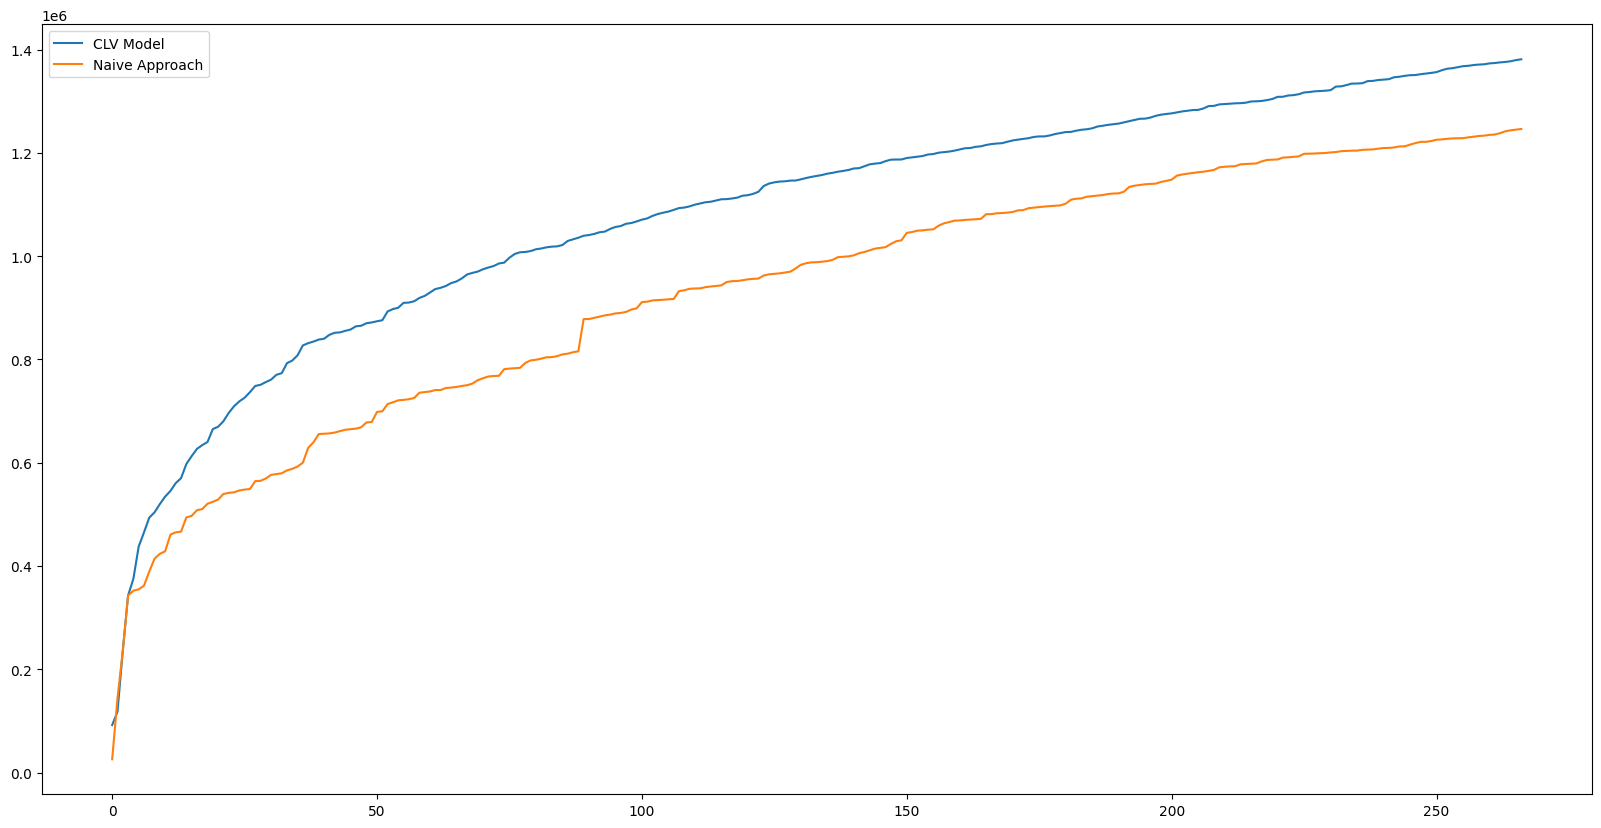

In [56]:
plt.figure(figsize=(20, 10))
plt.plot(cumsum_clv, label='CLV Model')
plt.plot(cumsum_mon, label='Naive Approach')
plt.legend()

#### Model Re-Train

Now that we've established that the model approach works, we can re-train the model on the entire dataset. Let's find out who are the top 10 most valuable customers.

In [61]:
rfm = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', monetary_value_col = 'Sales')
rfm = rfm.loc[rfm.frequency > 0, :]

In [62]:
#BG/NBD
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(rfm['frequency'], rfm['recency'], rfm['T'])

<lifetimes.BetaGeoFitter: fitted with 2698 subjects, a: 0.01, alpha: 113.48, b: 0.17, r: 2.01>

In [63]:
#GG
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(rfm['frequency'],
        rfm['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2698 subjects, p: 2.11, q: 3.49, v: 492.82>


In [64]:
#CLV model
clv = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    rfm['frequency'],
    rfm['recency'],
    rfm['T'],
    rfm['monetary_value'],
    time=4, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
)

rfm['clv'] = clv

These are the top 10 most valuable customers and how much they are worth in the next 3 months

In [65]:
rfm.sort_values('clv', ascending=False).head(10)

,frequency,recency,T,monetary_value,clv
CustomerID,,,,,
14646,42.0,338.0,345.0,6390.643810,69859.113496
18102,23.0,356.0,358.0,9663.103913,57104.445908
17450,25.0,357.0,358.0,7638.382000,48961.124497
14096,15.0,90.0,92.0,3747.131333,33840.307182
14911,126.0,364.0,364.0,1081.672698,33712.256190
12415,15.0,313.0,328.0,7860.210000,32918.919404
14156,42.0,362.0,362.0,2787.081667,29455.018645
17511,25.0,357.0,364.0,3274.292800,20791.950148
16029,38.0,335.0,364.0,2034.808421,19397.538714
